# Molecular Maps: PCA using RDKIT, part 2

Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)
Version: 0.0.1

## Example 1: PCA to distinguish between rings and chains

For this example we define in SMILES string two groups of molecules with different substituents, such as -CH3, -O, -F, -Cl, and- I , in molecules with six carbons 1) in a ring and 2) in chain. Those molecules would be added to a list, additionally we add a 'certain' property , this could be used later as a flag.

In [34]:
import sys
import os
SRC_DIR='..'

In [35]:
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.manifold import TSNE

import hdbscan

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')

In [39]:
df = pd.read_pickle('../data/../data/extended_db_Zindo_Nov_2019_V5_cannfp_clust_lem.pkl').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))
#df.head(2)

Column names: ['smiles', 'inchikey', 'fpfailp', 'fpfail', 'smi_pre', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nogood', 'nogoodp', 'mol', 'molp', 'morganfps-b', 'morganfps-b8', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'MolWt', 'MolWtp', 'gapdft', 'gapmopac', 'gapz', 'cluster', 'clusterprob']
Table Shape: (5771, 55)


In [40]:
df=df[df['lambda_tddft (nm)']>0]
df=df[df['lambda_sTDA (nm)']>0]
#df=df[df['cluster']>-1]
print('Table Shape: {}'.format(df.shape))

Table Shape: (1051, 55)


In [51]:
df['stda_dft'] = df['lambda_tddft (nm)'].values[:]- df[ 'lambda_sTDA (nm)'].values[:]

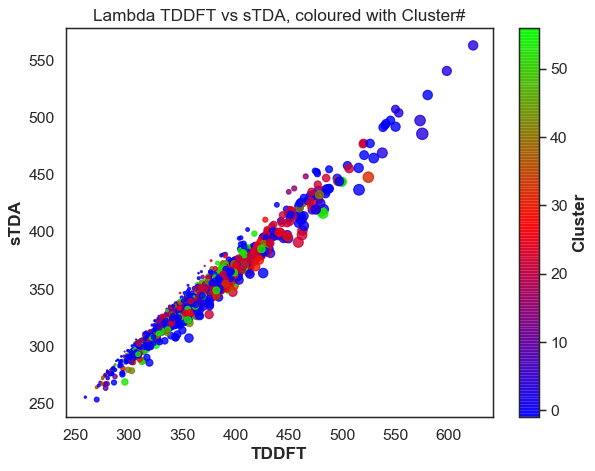

In [70]:
plt.figure(figsize=(8,6))
plt.scatter(df['lambda_tddft (nm)'].values[:], df[ 'lambda_sTDA (nm)'].values[:], marker='o', c=df[ 'cluster'], cmap='brg', s=df['stda_dft'],alpha=.8,)
#plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 

plt.xlabel('TDDFT')
plt.ylabel('sTDA')
plt.title('Lambda TDDFT vs sTDA, coloured with Cluster#')
cbar = plt.colorbar()
cbar.set_label('Cluster')
utils.save_figure(results_path,'tddft-stda-diff_lem')
plt.show()

In [48]:
counts = df.cluster.value_counts()
counts[1:8]

22    156
53     77
3      54
15     38
32     25
2      24
26     23
Name: cluster, dtype: int64

In [53]:
for e in counts[1:8].keys():
    values = df[df.cluster == e]['stda_dft'].values[:]
    values.s

AttributeError: 'numpy.ndarray' object has no attribute 's'

In [54]:
cols = ['cluster','mean','std','max','min']
mat= pd.DataFrame(columns=cols)
mat

,cluster,mean,std,max,min


In [55]:

for e in counts[:].keys():
    values = df[df.cluster == e]['stda_dft'].values[:]
    mat.loc[e] =[e, values.mean(),values.std(),np.abs(values.max()),np.abs(values.min())]
    #print('cluster#{}, mean = {}, max= {}'.format(e, values.mean(),values.max()))

In [56]:
cmin = mat.loc[mat['min'].idxmin()].cluster

In [57]:
cmax = mat.loc[mat['max'].idxmax()].cluster

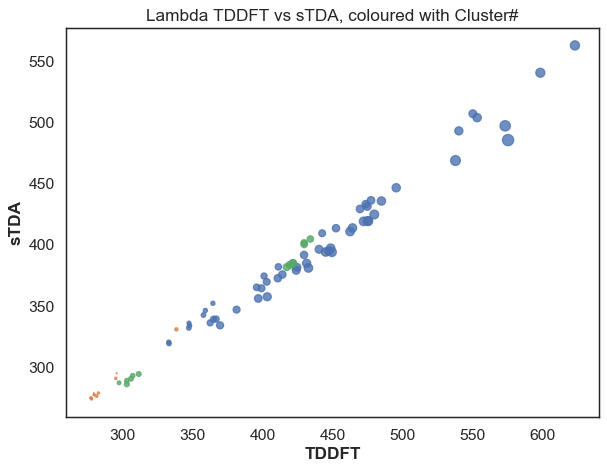

In [58]:
plt.figure(figsize=(8,6))
pa = df[df.cluster ==cmax]
plt.scatter(pa['lambda_tddft (nm)'].values[:], pa[ 'lambda_sTDA (nm)'].values[:], marker='o' , s=pa['stda_dft'],alpha=.8,)
pa = df[df.cluster ==cmin]
plt.scatter(pa['lambda_tddft (nm)'].values[:], pa[ 'lambda_sTDA (nm)'].values[:], marker='o' , s=pa['stda_dft'],alpha=.8,)
pa = df[df.cluster ==23]
plt.scatter(pa['lambda_tddft (nm)'].values[:], pa[ 'lambda_sTDA (nm)'].values[:], marker='o' , s=pa['stda_dft'],alpha=.8,)
#pb = df[df.cluster ==23]
#plt.scatter(pb['lambda_tddft (nm)'].values[:], pb[ 'lambda_sTDA (nm)'].values[:], marker='^' , s=40,alpha=.8,)
#plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 

plt.xlabel('TDDFT')
plt.ylabel('sTDA')
plt.title('Lambda TDDFT vs sTDA, coloured with Cluster#')

plt.show()

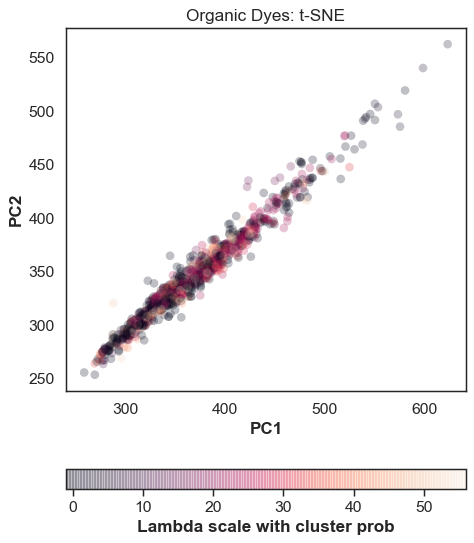

In [59]:
plt.figure(figsize=(6,8))
plot_kwds={'alpha':.25, 's':50, 'linewidths':.1}

#plt.scatter(tsne_X.T[0], tsne_X.T[1], c=df[ 'lambda_sTDA (nm)'].values[:], cmap='rainbow' )
plt.scatter(df['lambda_tddft (nm)'].values[:], df[ 'lambda_sTDA (nm)'].values[:], c=df[ 'cluster'], **plot_kwds )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Organic Dyes: t-SNE')

cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Lambda scale with cluster prob')
plt.show()

In [11]:
#df['diff_td_sta'] = df['lambda_tddft (nm)'].values[:]- df[ 'lambda_sTDA (nm)'].values[:]
#df['stda_dft'] = df['lambda_tddft (nm)'].values[:]- df[ 'lambda_sTDA (nm)'].values[:]

In [60]:
counts = df.cluster.value_counts()
counts[1:10]

22    156
53     77
3      54
15     38
32     25
2      24
26     23
51     22
29     19
Name: cluster, dtype: int64

In [61]:
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
sns.set(style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
sns.set_color_codes()
color_palette = sns.color_palette()

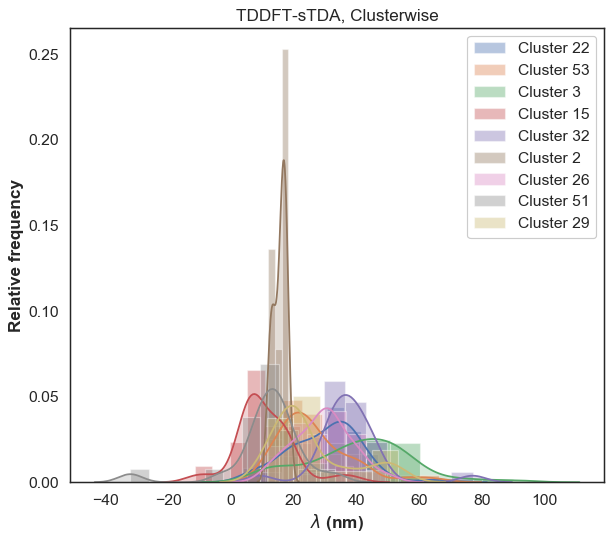

In [63]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax=[]
names=[]
for e in counts[1:10].keys():
    label='Cluster {}'.format(e)
    ax=sns.distplot(df[df['cluster']==e]['stda_dft'].values,kde_kws={"shade": True},label=label)
    names.append('Cluster {}'.format(e))

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Relative frequency')
plt.title('TDDFT-sTDA, Clusterwise')

ax.legend(names)
#header_legend('',  title='Clusters', loc='upper right',bbox_to_anchor=(1.15,1.0))
utils.save_figure(results_path,'tddft-stda-diff-cluster-lem')
plt.show()

In [64]:
df=df[df['lambda_z (nm)']>0]

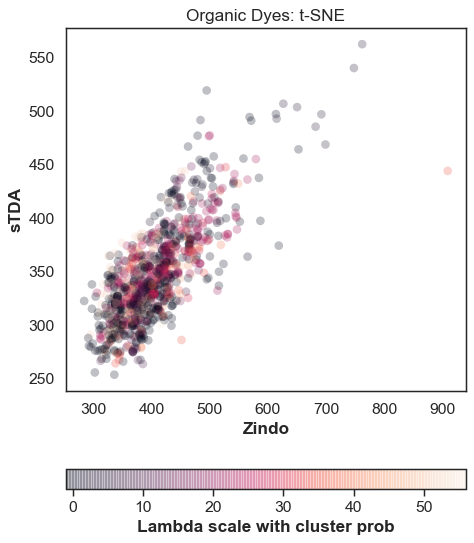

In [65]:
plt.figure(figsize=(6,8))
plot_kwds={'alpha':.25, 's':50, 'linewidths':.1}

#plt.scatter(tsne_X.T[0], tsne_X.T[1], c=df[ 'lambda_sTDA (nm)'].values[:], cmap='rainbow' )
plt.scatter(df['lambda_z (nm)'].values[:], df[ 'lambda_sTDA (nm)'].values[:], c=df[ 'cluster'], **plot_kwds )

plt.xlabel('Zindo')
plt.ylabel('sTDA')
plt.title('Organic Dyes: t-SNE')

cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Lambda scale with cluster prob')
plt.show()

In [66]:
df['diff_z_sta'] = df['lambda_z (nm)'].values[:]- df[ 'lambda_sTDA (nm)'].values[:]

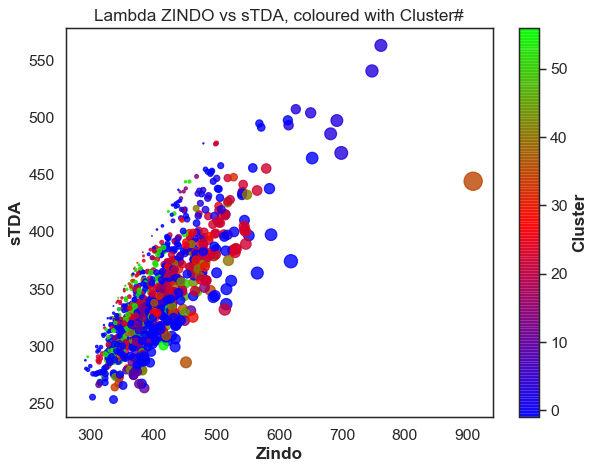

In [68]:
plt.figure(figsize=(8,6))
plt.scatter(df['lambda_z (nm)'].values[:], df[ 'lambda_sTDA (nm)'].values[:], marker='o', c=df[ 'cluster'], cmap='brg', s=df['diff_z_sta'].values[:]*.5,alpha=.8,)
#plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], 

plt.xlabel('Zindo')
plt.ylabel('sTDA')
plt.title('Lambda ZINDO vs sTDA, coloured with Cluster#')
cbar = plt.colorbar()
cbar.set_label('Cluster')
utils.save_figure(results_path,'zindo-stda-diff_lem')
plt.show()

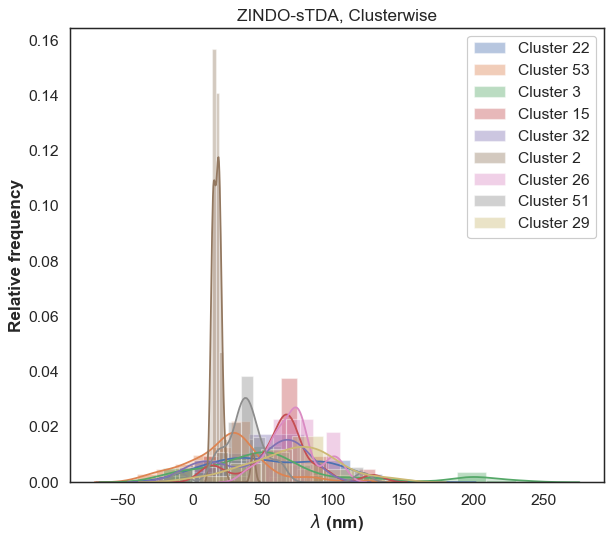

In [71]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax=[]
names=[]
for e in counts[1:10].keys():
    label='Cluster {}'.format(e)
    ax=sns.distplot(df[df['cluster']==e]['diff_z_sta'].values,kde_kws={"shade": True},label=label)
    names.append('Cluster {}'.format(e))

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Relative frequency')
plt.title('ZINDO-sTDA, Clusterwise')

ax.legend(names)
#header_legend('',  title='Clusters', loc='upper right',bbox_to_anchor=(1.15,1.0))
utils.save_figure(results_path,'zindo-stda-diff-cluster_lem')
plt.show()